In [64]:
import pandas as pd
import re
import numpy as np
import json
import os
import folium
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [2]:
combined=pd.DataFrame()
path=r'C:\Users\Bekbol\Desktop\relog'
json_files = [pos_json for pos_json in os.listdir(path) if pos_json.endswith('.json')]
for i in range(len(json_files)):
    file=os.path.join(path, json_files[i])
    data = json.load(open(file))
    file_names=pd.DataFrame.from_dict(data, orient='columns')
    locations=pd.json_normalize(data['locations'])
    result = pd.concat([file_names, locations], axis=1, join="inner")
    A=np.asarray(data['matrix'])
    json_files[i]=pd.concat([result,pd.DataFrame(A)],axis=1,ignore_index=True)
    json_files[i].drop([0,1],axis=1, inplace=True)
    #combined=combined.append(temp,ignore_index=True)  
    

In [3]:
test1=json_files[0]
test1=test1.rename(columns={2: 'K', 3:'lat', 4: 'lng'})
test2=json_files[1]
test2=test2.rename(columns={2: 'K', 3:'lat', 4: 'lng'})
test3=json_files[2]
test3=test3.rename(columns={2: 'K', 3:'lat', 4: 'lng'})
test4=json_files[3]
test4=test4.rename(columns={2: 'K', 3:'lat', 4: 'lng'})
result1=test1.copy()
result2=test2.copy()
result3=test3.copy()
result4=test4.copy()

In [4]:
print(result1.describe().T)
print(result2.describe().T)
print(result3.describe().T)
print(result4.describe().T)

     count          mean          std        min          25%           50%  \
K    972.0     30.000000     0.000000  30.000000    30.000000     30.000000   
lat  972.0     43.250994     0.037501  43.123632    43.229708     43.246060   
lng  972.0     76.910736     0.042077  76.777349    76.879965     76.912133   
5    972.0  11203.723148  6810.423186   0.000000  5297.500000  11899.650000   
6    972.0   6624.780247  4407.226243   0.000000  3915.075000   5733.500000   
..     ...           ...          ...        ...          ...           ...   
972  972.0  10168.464300  5469.767472   0.000000  5946.775000   9398.600000   
973  972.0  10719.485288  6034.792496   0.000000  5671.825000  10708.050000   
974  972.0  12272.484774  4875.539475   0.000000  8967.850000  11564.100000   
975  972.0   8945.942387  5348.955211   0.000000  4482.700000   8427.750000   
976  972.0   7136.619033  4899.936331   0.000000  3231.925000   5644.800000   

              75%           max  
K       30.000000

In [13]:
need1=result.iloc[:, 2:5]

In [15]:
need1.dropna(axis=0,how='any',subset=['lat','lng'],inplace=True)

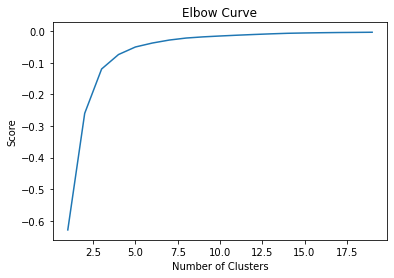

In [18]:
K_clusters = range(1,20)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = need1[['lat']]
X_axis = need1[['lng']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In the plot, we see that the graph levels off slowly after 5 clusters. This implies that addition of more clusters will not help us that much.

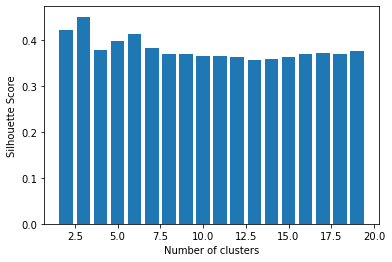

In [73]:
silhouette_scores = [] 

for n_cluster in range(2, 20):
    silhouette_scores.append( 
        silhouette_score(need1.iloc[:, 1:3], KMeans(n_clusters = n_cluster).fit_predict(need1.iloc[:, 1:3]))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15,16,17,18,19] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

from this graph, it can be seen that number of cluster must be equal to 3 or 6

In [81]:
kmeans = KMeans(n_clusters = 6, init ='k-means++')
kmeans.fit(need1.iloc[:, 1:3]) 
need1['cluster_label'] = kmeans.fit_predict(need1.iloc[:, 1:3])
centers = kmeans.cluster_centers_ 
labels = kmeans.predict(need1.iloc[:, 1:3]) 

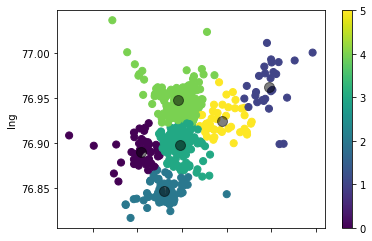

In [52]:
need1.plot.scatter(x = 'lat', y = 'lng', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

In [50]:
m = folium.Map(location=[need1.lat.mean(), need1.lng.mean()], zoom_start=9, 
               tiles='OpenStreet Map')
for _, row in need1.iterrows():
    folium.CircleMarker(
        location=[row.lat, row.lng],
        radius=5,
        #popup=re.sub(r'[^a-zA-Z ]+', '', row.K),
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)
    
m    


In [65]:
agglom = AgglomerativeClustering(n_clusters=6, linkage='average').fit(need1.iloc[:, 1:3])

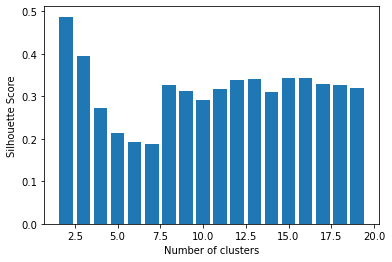

In [76]:
silhouette_scores = [] 
for n_cluster in range(2, 20):
    silhouette_scores.append( 
        silhouette_score(need1.iloc[:, 1:3], AgglomerativeClustering(n_clusters=n_cluster, linkage='average').fit_predict(need1.iloc[:, 1:3])))
k = [2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15,16,17,18,19] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show()     

In [100]:
agglom = AgglomerativeClustering(n_clusters=6, linkage='average').fit(need1.iloc[:, 1:3])
labels = agglom.labels_ 


In [101]:
for i in range(len(labels)):
    need1.at[i,'agglomer']=labels[i]

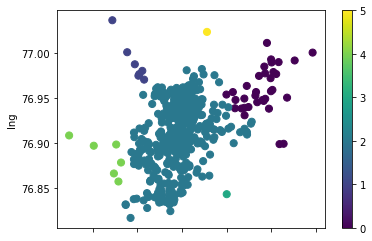

In [102]:
need1.plot.scatter(x = 'lat', y = 'lng', c=labels, s=50, cmap='viridis')